# Implementation of "Dreamy Blur"
Emulation of camera lens smudging and blurring, following [demonstrated approaches in SVG-based CSS maniplation.](https://yuanchuan.dev/dreamy-blur)

In [325]:
# base libraries
import numpy as np
from scipy import linalg
from scipy import signal
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import math
import random

# necessary for blending
from PIL import Image

# save structures, if needed
import pickle

## Background
I initially came upon the article linked above from a post on Y Combinator's _Hacker News_. The premise is rather simple: how can we emulate the type of blurring that results from fingers smudging against a camera lens? There isn't an exact "style" of blur that we're looking for; rather, the blur should be somewhat random and stochastic in a manner that resembles, well, a dream-like image (which lends its name to the original author's article).


My implementation of the article's SVG-based CSS methods instead uses native code and processing in Python (since the browser canvas is limited to CSS methods or, if allowed, any JavaScript). This is done in order to allow for blurring where the user has zero interaction with the system - aside from declaring the input image. Stochastic processes in this fashion are used to train current in-camera JPEG processing algorithms that compensate for lens aberrations or faults otherwise.

## Implementation
Here, I outline several functions that are necessary for manipulating the image canvas. These are ensembled together, once completed, in a later compositor with the input image as the primary layer.

[The image I chose is located here on Pixabay,](https://pixabay.com/images/id-736886/) a site for license-free images.

### Functions

In [2]:
# Moffat blur, as an alternative to the Gaussian PSF
def moffat_blur(x_dim: int, y_dim: int, k: int, l: int, s_1: int, s_2: int, rho: int, beta: int) -> np.ndarray:
    # define a new array to hold the filter
    p = np.zeros((x_dim, y_dim))

    # iterate over all elements
    for i in range(x_dim):
        for j in range(y_dim):
            # set index value to result of Moffat blur
            scale_matrix = np.asmatrix(np.array([[i - k], [j - l]]))
            orientation_matrix = np.asmatrix(np.array([[s_1**2, rho**2], [rho**2, s_2**2]]))

            # per-element calculation
            p[i][j] = (1 + np.transpose(scale_matrix) * linalg.inv(orientation_matrix) * scale_matrix) ** -beta
    
    # done!
    return p

In [419]:
# a wrapper for scipy convolution on images with multiple channels
def conv_wrapper(img: np.ndarray, img_x: int, img_y: int, img_z: int, filter: np.ndarray) -> np.ndarray:
    # new placeholder for filter
    x_copy = np.zeros((img_x, img_y, img_z))

    # apply filter
    for z in range(3):
        x_copy[:,:,z] = signal.fftconvolve(img[:,:,z], filter, mode='same')

    # convert to range [0, 255]
    x_copy = np.uint8(x_copy)

    return x_copy

### Usage

In [415]:
# get image from local storage
img = plt.imread('./data/mountains-736886_640.jpg')
img_x = len(img)
img_y = len(img[0])
img_z = len(img[0][0])

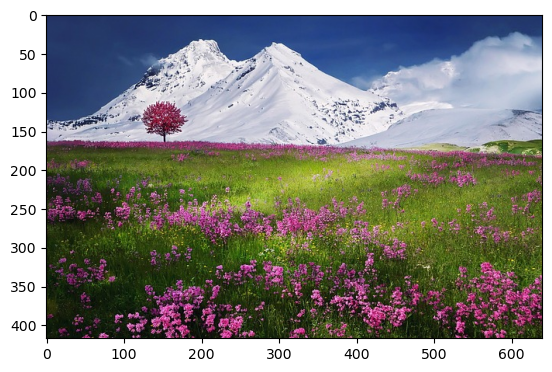

In [425]:
plt.imshow(img)

In [411]:
# generating a "shaky" blurred kernel using Moffat PSF
moffat_layer = moffat_blur(30, 30, 15, 15, 3, 14, 0, 3)
moffat_layer_scaled = moffat_layer * 0.0175

In [420]:
# apply Moffat kernel to orinal image
base_1 = conv_wrapper(img, img_x, img_y, img_z, moffat_layer_scaled)

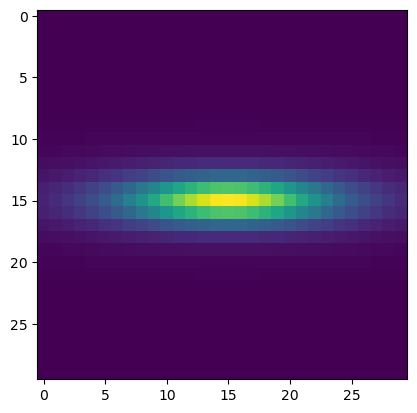

In [424]:
plt.imshow(moffat_layer)

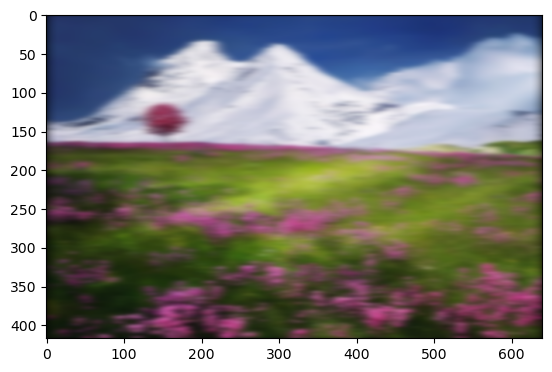

In [423]:
plt.imshow(base_1)

In [402]:
plt.imsave('./data/moffat_blur_output.jpg', x_copy / np.amax(x_copy))

In [408]:
img_pil = Image.fromarray(img)
x_pil = Image.fromarray(x_copy)
im3 = Image.blend(img_pil, x_pil, 0.75)

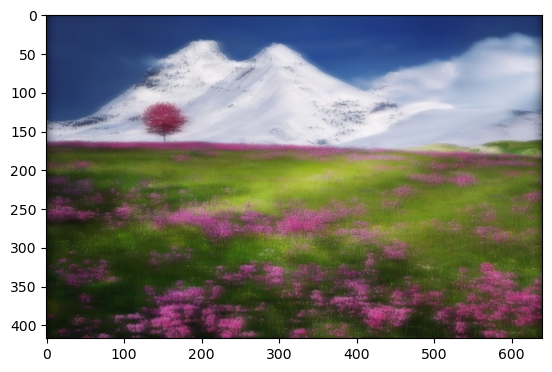

In [409]:
plt.imshow(im3)